In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Define path to the data directory
data_dir = Path('../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/')

data_dir

PosixPath('../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database')

In [3]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = data_dir / 'Normal'
Tuberculosis_cases_dir = data_dir / 'Tuberculosis'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.png')
Tuberculosis_cases = Tuberculosis_cases_dir.glob('*.png')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in Tuberculosis_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,../input/tuberculosis-tb-chest-xray-dataset/TB...,0
1,../input/tuberculosis-tb-chest-xray-dataset/TB...,0
2,../input/tuberculosis-tb-chest-xray-dataset/TB...,0
3,../input/tuberculosis-tb-chest-xray-dataset/TB...,1
4,../input/tuberculosis-tb-chest-xray-dataset/TB...,0


In [4]:
train_data.shape

(4200, 2)

0    3500
1     700
Name: label, dtype: int64


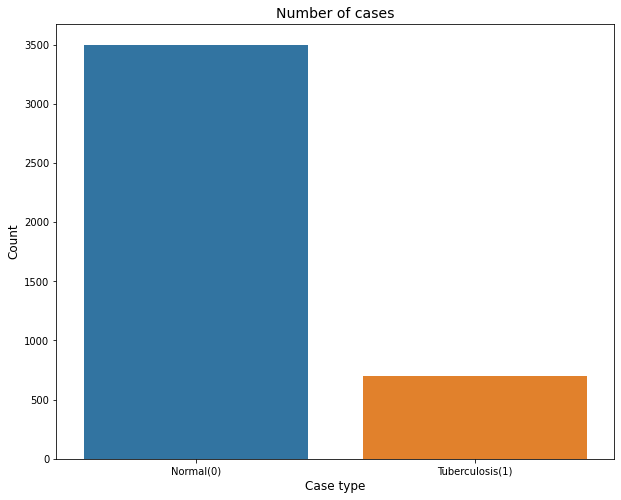

In [5]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Tuberculosis(1)'])
plt.show()

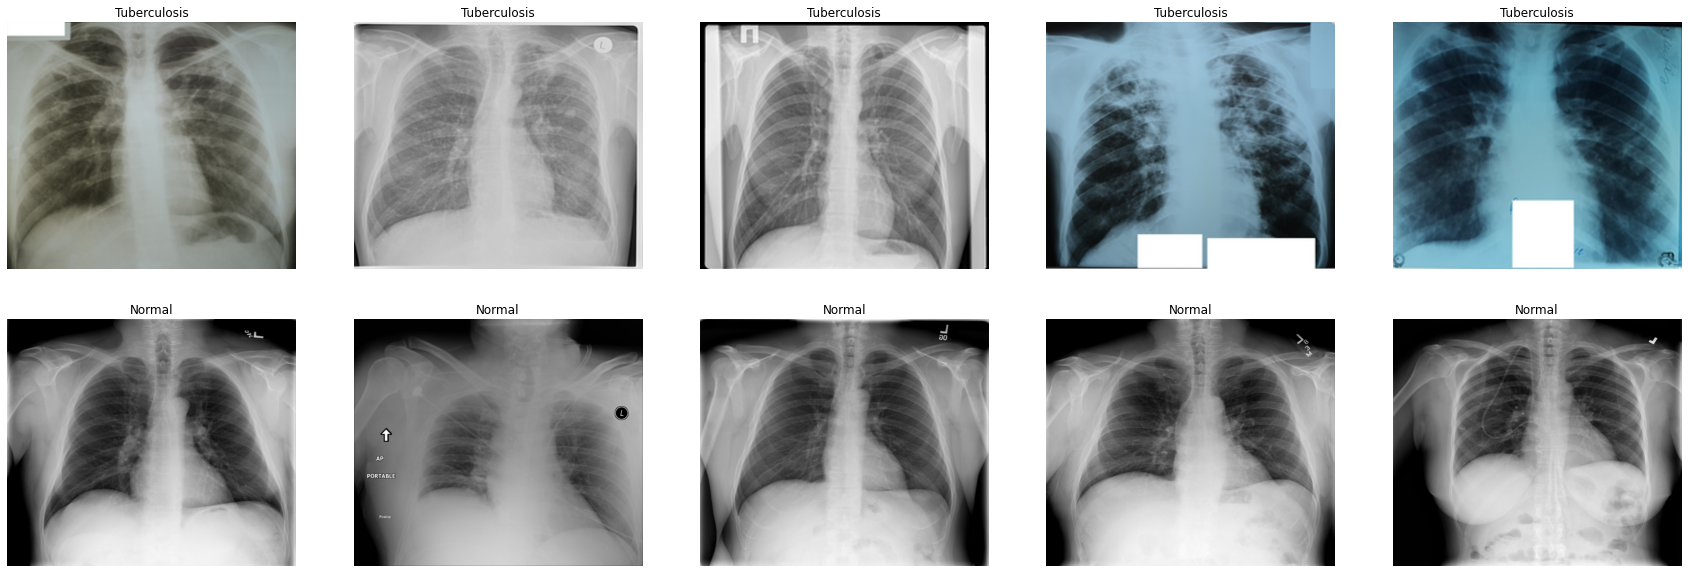

In [6]:
# Get few samples for both the classes
Tuberculosis_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = Tuberculosis_samples + normal_samples
del Tuberculosis_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Tuberculosis")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [7]:
from tqdm import tqdm
train_normal = data_dir / 'Normal'
train_Tuberculosis = data_dir / 'Tuberculosis'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.png')
Tuberculosis_cases =Tuberculosis_cases_dir.glob('*.png')
train_data = []
train_labels = []
from keras.utils.np_utils import to_categorical



for img in tqdm(normal_cases):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (28,28))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'normal'
    train_data.append(img)
    train_labels.append(label)
                      
# Tuberculosis cases        
for img in tqdm(Tuberculosis_cases):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (28,28))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'Tuberculosis'
    train_data.append(img)
    train_labels.append(label)
    
# Convert the list into numpy arrays

train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)

3500it [01:08, 51.33it/s]
700it [00:12, 56.99it/s]


Total number of validation examples:  (4200, 28, 28, 3)
Total number of labels: (4200,)


In [8]:
train_data1[1]

array([[[0.05098039, 0.05098039, 0.05098039],
        [0.04313725, 0.04313725, 0.04313725],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.04705882, 0.04705882, 0.04705882],
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569]],

       [[0.04705882, 0.04705882, 0.04705882],
        [0.03529412, 0.03529412, 0.03529412],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.04313725, 0.04313725, 0.04313725],
        [0.03921569, 0.03921569, 0.03921569],
        [0.04313725, 0.04313725, 0.04313725]],

       [[0.04705882, 0.04705882, 0.04705882],
        [0.03921569, 0.03921569, 0.03921569],
        [0.04313725, 0.04313725, 0.04313725],
        ...,
        [0.03921569, 0.03921569, 0.03921569],
        [0.03921569, 0.03921569, 0.03921569],
        [0.04313725, 0.04313725, 0.04313725]],

       ...,

       [[0.03137255, 0.03137255, 0.03137255],
        [0.03137255, 0.03137255, 0.03137255],
        [0.03137255, 0

In [9]:
train_labels1.shape

(4200,)

In [10]:
train_data1.shape

(4200, 28, 28, 3)

In [11]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1.head()

,label
0,normal
1,normal
2,normal
3,normal
4,normal


In [12]:
train_labels1['label']=train_labels1['label'].map({'normal':0,'Tuberculosis':1})
train_labels1['label'].unique()

array([0, 1])

In [13]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
train_rows=len(train_data1)
train_data1 = train_data1.reshape(train_rows,-1)
train_data2, train_labels2 = smt.fit_resample(train_data1, train_labels1)

0    3500
1    3500
Name: label, dtype: int64


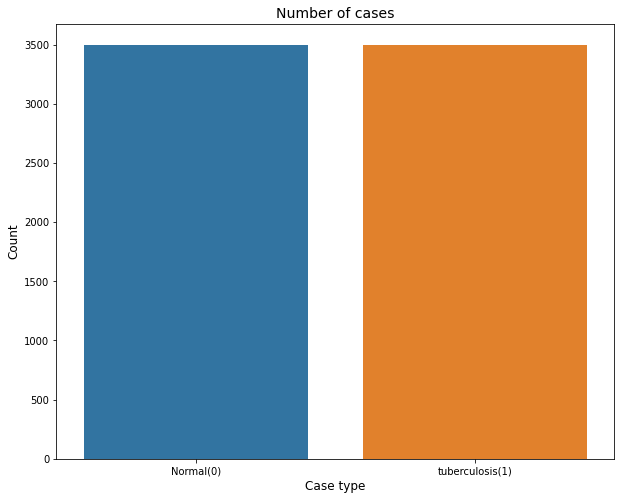

In [14]:
cases_count1 = train_labels2['label'].value_counts()
print(cases_count1)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count1.index, y= cases_count1.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'tuberculosis(1)'])
plt.show()

In [15]:
train_data2.shape

(7000, 2352)

In [16]:
train_labels2.shape

(7000, 1)

In [17]:
train_labels2

,label
0,0
1,0
2,0
3,0
4,0
...,...
6995,1
6996,1
6997,1
6998,1


In [18]:
train_data2 =train_data2.reshape(-1,28,28,3)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data2, train_labels2, test_size=0.13, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

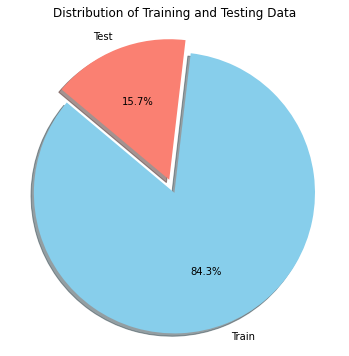

In [20]:
import matplotlib.pyplot as plt

# Calculate the sizes of each dataset
train_size = len(X_train)
test_size = len(X_test)

# Data to plot
sizes = [train_size, test_size]
labels = ['Train', 'Test']
colors = ['skyblue', 'salmon']
explode = (0.1, 0)  # explode 1st slice (Train)

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Training and Testing Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


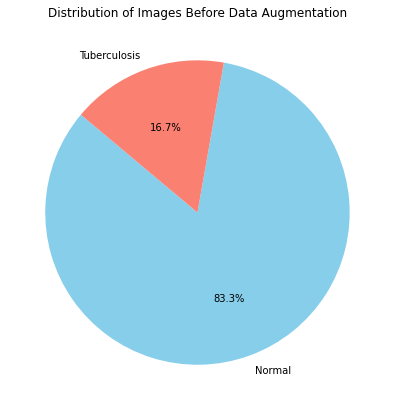

In [21]:
# Get the counts for each class before data augmentation
cases_count_before = train_labels1['label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(7, 7))
plt.pie(cases_count_before, labels=['Normal', 'Tuberculosis'], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Distribution of Images Before Data Augmentation')
plt.show()


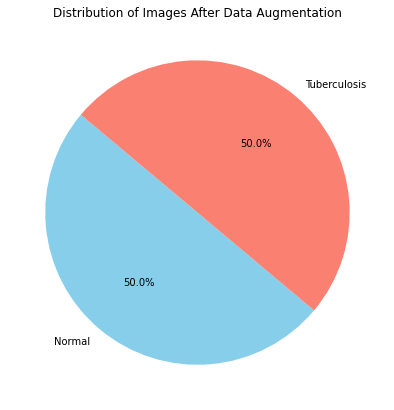

In [22]:
# Get the counts for each class after data augmentation
cases_count_after = train_labels2['label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(7, 7))
plt.pie(cases_count_after, labels=['Normal', 'Tuberculosis'], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Distribution of Images After Data Augmentation')
plt.show()


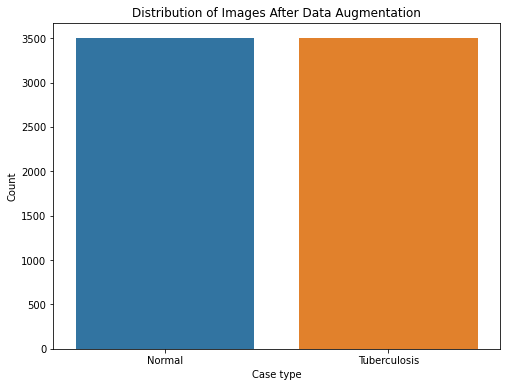

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts for each class after data augmentation
cases_count_after = train_labels2['label'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=cases_count_after.index, y=cases_count_after.values)
plt.title('Distribution of Images After Data Augmentation')
plt.xlabel('Case type')
plt.ylabel('Count')
plt.xticks(range(len(cases_count_after.index)), ['Normal', 'Tuberculosis'])
plt.show()


In [25]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import  layers, models
# Define your data augmentation layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Create your model
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(28, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(640, activation='tanh'),
    layers.Dropout(0.5),  # Dropout during training
    layers.Dense(564, activation='tanh'),
    layers.Dropout(0.5),  # Dropout during training
    layers.Dense(64, activation='tanh'),
    layers.Dense(2)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(np.array(X_train), np.array(y_train), epochs=20,validation_data=(X_val, y_val) , callbacks=[early_stopping], verbose=1)

# Evaluate the model on the validation set
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(y_test))
print('Test accuracy:', test_acc)



Epoch 1/20
153/153 [==============================] - 6s 25ms/step - loss: 0.3725 - accuracy: 0.8171 - val_loss: 0.1809 - val_accuracy: 0.9310
Epoch 2/20
153/153 [==============================] - 4s 23ms/step - loss: 0.2446 - accuracy: 0.9002 - val_loss: 0.1981 - val_accuracy: 0.9204
Epoch 3/20
153/153 [==============================] - 4s 23ms/step - loss: 0.1925 - accuracy: 0.9236 - val_loss: 0.1439 - val_accuracy: 0.9392
Epoch 4/20
153/153 [==============================] - 4s 23ms/step - loss: 0.1739 - accuracy: 0.9304 - val_loss: 0.3423 - val_accuracy: 0.8621
Epoch 5/20
153/153 [==============================] - 4s 23ms/step - loss: 0.2010 - accuracy: 0.9181 - val_loss: 0.1308 - val_accuracy: 0.9499
Epoch 6/20
153/153 [==============================] - 4s 29ms/step - loss: 0.1685 - accuracy: 0.9331 - val_loss: 0.1890 - val_accuracy: 0.9228
Epoch 7/20
153/153 [==============================] - 4s 23ms/step - loss: 0.1364 - accuracy: 0.9472 - val_loss: 0.1384 - val_accuracy: 0.9491

In [26]:
train_labels2['label'].unique()

array([0, 1])

In [27]:
test_data = []
image='/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-119.png'
img = cv2.imread(str(image))
img = cv2.resize(img, (28,28))
if img.shape[2] ==1:
    img = np.dstack([img, img, img])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=np.array(img)
img = img/255
test_data.append(img)
    
# Convert the list into numpy arrays

test_data1 = np.array(test_data)

In [28]:
test_data1.shape

(1, 28, 28, 3)

In [29]:
a=model.predict(np.array(test_data1))
a

array([[-3.0850735,  2.735203 ]], dtype=float32)

In [30]:
np.argmax(a)

1

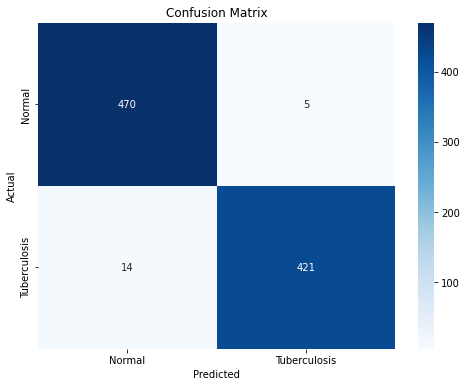

              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       475
Tuberculosis       0.99      0.97      0.98       435

    accuracy                           0.98       910
   macro avg       0.98      0.98      0.98       910
weighted avg       0.98      0.98      0.98       910

Precision: 0.9882629107981221
Recall: 0.967816091954023
F1-Score: 0.9779326364692219


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tuberculosis'], yticklabels=['Normal', 'Tuberculosis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
cr = classification_report(y_test, y_pred_classes, target_names=['Normal', 'Tuberculosis'])
print(cr)

from sklearn.metrics import precision_score, recall_score, f1_score

#  Precision
precision = precision_score(y_test, y_pred_classes)
print('Precision:', precision)

#  Recall
recall = recall_score(y_test, y_pred_classes)
print('Recall:', recall)

#  F1-Score
f1 = f1_score(y_test, y_pred_classes)
print('F1-Score:', f1)

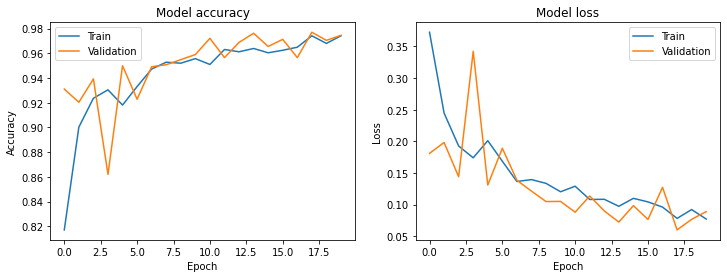

In [32]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plotting training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [33]:
model.save('my_model1')

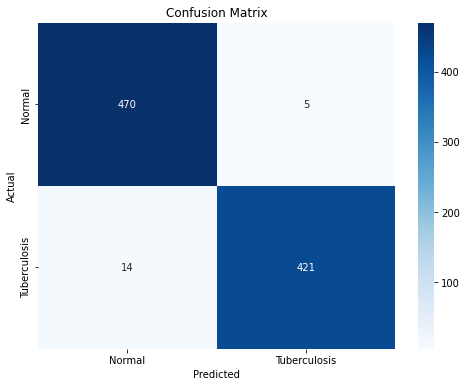

In [34]:
# Making predictions on the test set
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tuberculosis'], yticklabels=['Normal', 'Tuberculosis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Classification Report
cr = classification_report(y_test, y_pred_classes, target_names=['Normal', 'Tuberculosis'])
print(cr)

              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       475
Tuberculosis       0.99      0.97      0.98       435

    accuracy                           0.98       910
   macro avg       0.98      0.98      0.98       910
weighted avg       0.98      0.98      0.98       910



In [36]:
new_model = tf.keras.models.load_model('./my_model1')

# Check its architecture
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 28)        784       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        16192     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

In [38]:
a=new_model.predict(np.array(test_data1))
a

array([[-3.0850735,  2.735203 ]], dtype=float32)

In [39]:
image='../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-10.png'
img = cv2.imread(str(image))

In [40]:
# Importing Image module from PIL package 
from PIL import Image 
import PIL 
  
# creating a image object (main image) 
im1 = Image.open(image) 
  
# save a image using extension
im1 = im1.save("tb1.jpg")